# Проект для «Викишоп»(BERT)

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# !pip install numpy -q
# !pip install tqdm -q
# !pip install scikit-learn -q
# !pip install torch -q
# !pip install transformers -q
# !pip install xgboost -q

In [2]:
import warnings
import re
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from xgboost import XGBClassifier
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
try: 
    df = pd.read_csv('toxic_comments.csv')
except FileNotFoundError:
    df = pd.read_csv('####')

In [5]:
print('Общая информация о данных')
df.info()
print('Описательная статистика')
display(df.describe())
print('Взгляд на первые 5 строк')
display(df.head())
print('Проверка на дубликаты')
print('Нет дублей') if df.duplicated().sum() == 0 else print(df.duplicated().sum()) 

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
Описательная статистика


,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


Взгляд на первые 5 строк


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Проверка на дубликаты
Нет дублей


In [6]:
# Оценим баланс классов
df.toxic.value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

По результатам предварительного анализа данных можно сделать следующие выводы: Пропусков в данных нет, дубликатов нет, типы данных соответствуют содержанию, целевой признак распределен неравномерно, что может привести к переобучению модели.

Уменьшим выборку данных

In [7]:
df_ds = df.sample(frac=0.0225, random_state=400)

Посмотрим на распределение длины текстов

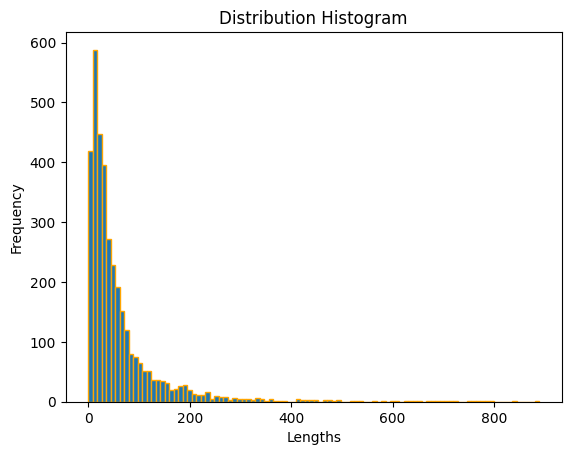

In [8]:
def str_len(s):
    pattern = r"[^a-zA-Z\n\s]+"
    cleaned_text = re.sub(pattern, "", s)
    length = len(re.findall(r"[\w']+", cleaned_text))
    return length
    
lengths = df_ds['text'].apply(lambda s: str_len(s))

plt.hist(lengths, bins=100, edgecolor='orange')
plt.title("Distribution Histogram")
plt.xlabel("Lengths")
plt.ylabel("Frequency");

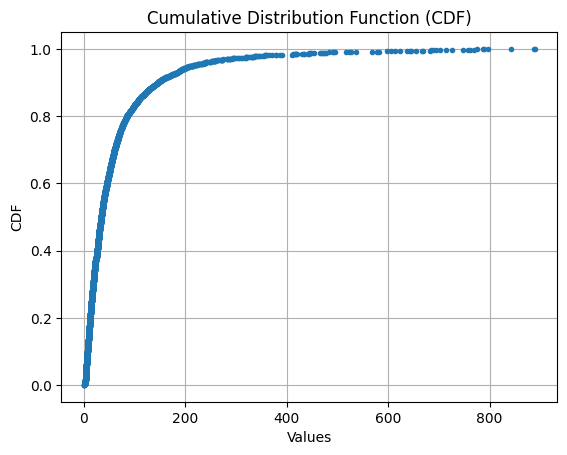

In [9]:
sorted_data = np.sort(lengths)
y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.plot(sorted_data, y, marker='.', linestyle='none')
plt.xlabel("Values")
plt.ylabel("CDF")
plt.title("Cumulative Distribution Function (CDF)")
plt.grid(True);

Как видно из графика CDF можно задать максимальную длину текста 200 и при этом захватить более 90% текстов по длине без отсечки. Что мы и сделаем.

Можно приступать к обучению модели

## Обучение

#### Подготовка данных

In [10]:
# Инициализируем модель и токенайзер
model_name = 'unitary/toxic-bert'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [11]:
# Что-бы данные сходились с распределением которое мы построили на предыдущем шаге
# уберем из них специальные симоволы, кроме некоторых
def str_clean(s):
    pattern = r"[^a-zA-Z\n\s\.]+"
    s = s.lower()
    return re.sub(pattern, "", s)
    
df_ds['text'] = df_ds['text'].apply(lambda s: str_clean(s))

In [12]:
# Токенизируем и сделаем паддинг нашего текста
max_sequence_length = 200

tokenized = df_ds['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, 
                                                                   max_length=max_sequence_length, 
                                                                   truncation=True, padding='max_length'))

In [13]:
# Конвертируем токены в более удобную структуру и создадим маску внимания
padded = np.stack(tokenized)
attention_mask = np.where(padded != 0, 1, 0)

#### Рассчёт эмбедингов

In [14]:
batch_size = 50
embeddings = []
for i in notebook.tqdm(range(tokenized.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings.logits.numpy())

  0%|          | 0/71 [00:00<?, ?it/s]

In [15]:
print(np.concatenate(embeddings).shape)
print(df_ds.shape)

(3550, 6)
(3584, 3)


При создании эмбедингов пропали 34(3584-3550) текста. Из-за особенностей обработки.

In [16]:
# Разобьём данные на выборки.
labels = df_ds['toxic'][:3550]
features = np.concatenate(embeddings)
# Делим данные на выборки
train_inputs, test_inputs, train_labels, test_labels = train_test_split(features, labels.values, shuffle=True,
                                                                        random_state=400, test_size=0.3)
# Оценим размеры выборок
print(train_inputs.shape, 'train_inputs')
print(test_inputs.shape, 'test_inputs')
print(train_labels.shape, 'train_labels')
print(test_labels.shape, 'test_labels')

(2485, 6) train_inputs
(1065, 6) test_inputs
(2485,) train_labels
(1065,) test_labels


#### Логистическая регрессия

In [17]:
%%time

# Инициализируем модель
model = LogisticRegression(solver='saga', random_state=400)

# Зададим параметры для перебора при поиске оптимальной модели
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Зададим скорер
f1_scorer = make_scorer(f1_score, average='binary')

# Запустим кросс валидацию и перебор параметров на тренировочной выборке
grid_search_lr = GridSearchCV(model, param_grid, cv=5, scoring=f1_scorer)
grid_search_lr.fit(train_inputs, train_labels)

print('Logistic Regression(saga solver)')
print(f'Best parameters: {grid_search_lr.best_params_}')
best_score = grid_search_lr.best_score_
print(f"Best Cross-Validation Score: {best_score:.4f}")

# Сохраним лучшую модель
best_model_log_reg = grid_search_lr.best_estimator_

Logistic Regression(saga solver)
Best parameters: {'C': 1, 'penalty': 'l1'}
Best Cross-Validation Score: 0.9200
CPU times: user 2.09 s, sys: 25.1 ms, total: 2.11 s
Wall time: 2.12 s


#### RandomForestClassifier

In [18]:
%%time

# Инициализация модели
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=400)

# Параметры для перебора при поиске оптимальной модели
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 1, 5, 10],
    'min_samples_split': [2, 5, 10],
}

# Запустим кросс валидацию и перебор параметров на тренировочной выборке
grid_search_rf = GridSearchCV(rf_classifier, param_grid, cv=5, scoring=f1_scorer)
grid_search_rf.fit(train_inputs, train_labels)

print('RandomForestClassifier')
print(f'Best parameters: {grid_search_rf.best_params_}')
print(f"Best Cross-Validation Score: {grid_search_rf.best_score_:.4f}")

# Сохраним лучшую модель
best_model_rand_for = grid_search_rf.best_estimator_

RandomForestClassifier
Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
Best Cross-Validation Score: 0.9138
CPU times: user 3min 14s, sys: 940 ms, total: 3min 15s
Wall time: 3min 25s


#### XGBoost

In [19]:
%%time

# Инициализируем классификатор XGBoost
xgb_classifier = XGBClassifier(n_estimators=100, random_state=400)

# Зададим сетку гиперпараметров и их возможные значения
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
}

# Запустим кросс валидацию и перебор параметров на тренировочной выборке
grid_search_xgb = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring=f1_scorer)
grid_search_xgb.fit(train_inputs, train_labels)

print('XGBoostClassifier')
print(f'Best parameters: {grid_search_xgb.best_params_}')
best_score = grid_search_xgb.best_score_
print(f"Best Cross-Validation Score: {best_score:.4f}")
best_model_xgb = grid_search_xgb.best_estimator_

XGBoostClassifier
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}
Best Cross-Validation Score: 0.9116
CPU times: user 18.2 s, sys: 496 ms, total: 18.7 s
Wall time: 11.9 s


Лучший результат показала логистическая регрессия.

#### Логистическая регрессия на тестовой выборке

In [20]:
# Make predictions for each model on the test data
log_reg_predictions = best_model_log_reg.predict(test_inputs)

# Evaluate the models using different metrics
log_reg_accuracy = accuracy_score(test_labels, log_reg_predictions)

log_reg_precision = precision_score(test_labels, log_reg_predictions)

log_reg_recall = recall_score(test_labels, log_reg_predictions)

log_reg_f1 = f1_score(test_labels, log_reg_predictions)

# Print and compare the evaluation metrics for the three models
print("Logistic Regression:")
print(f"Accuracy: {log_reg_accuracy:.4f}")
print(f"Precision: {log_reg_precision:.4f}")
print(f"Recall: {log_reg_recall:.4f}")
print(f"F1 Score: {log_reg_f1:.4f}")

Logistic Regression:
Accuracy: 0.9840
Precision: 0.9245
Recall: 0.9159
F1 Score: 0.9202


## Выводы

По метрике F1 с небольшим отрывом выигрывает логистическая регрессия. По скорости работы также выигрывает логистическая регрессия, в скорость работы входит кросс валидация. На втором месте по F1 метрике случайный лес. На втором месте по скорости работы XGB. Финальное значение F1 метрики которого удалось достичь при помощи логистической регрессии на тестовых данных составляет 0.9200. В итоге оптимальной моделью для классификации комментариев представляется логистическая регрессия.